Reference - Rayner BBands strategy: https://www.youtube.com/watch?v=57hsQz70vVE&t=70s & https://github.com/mikolaje/TradingTutorial/

Reference: https://greyhoundanalytics.com/blog/create-a-custom-indicator-in-vectorbt/

Reference: https://github.com/polakowo/vectorbt/issues/86

In [1]:
import vectorbt as vbt
import numpy
from numba import njit
import warnings

warnings.filterwarnings("ignore")

In [2]:
btc_price_1d = vbt.YFData.download("META",
                                   missing_index="drop",
                                  interval="1d",
                                  start="2020-01-01").get("Close")
btc_price_1d

Date
2019-12-31 05:00:00+00:00    205.250000
2020-01-02 05:00:00+00:00    209.779999
2020-01-03 05:00:00+00:00    208.669998
2020-01-06 05:00:00+00:00    212.600006
2020-01-07 05:00:00+00:00    213.059998
                                ...    
2023-08-14 04:00:00+00:00    306.190002
2023-08-15 04:00:00+00:00    301.950012
2023-08-16 04:00:00+00:00    294.290009
2023-08-17 04:00:00+00:00    285.089996
2023-08-18 04:00:00+00:00    283.250000
Name: Close, Length: 915, dtype: float64

In [3]:
@njit
def ma_strategy(close, window=730, 
                lower_multiplier=1,
                upper_multiplier=1):
    signal = numpy.full(close.shape, numpy.nan)
    for x in range(len(close)):
        if x >= window:
            mavg = numpy.mean(close[x-window:x])
            if close[x] < mavg * lower_multiplier:
                signal[x] = 1
            elif close[x] > mavg* upper_multiplier:
                signal[x] = -1
            else:
                signal[x]=0
    return signal

ma_indicator = vbt.IndicatorFactory(
    class_name = "ma_strategy",
    short_name = "ma",
    input_names = ["close"],
    param_names = ["window","lower_multiplier","upper_multiplier"],
    output_names = ["signal"]
    ).from_apply_func(
        ma_strategy,
        window=730,
        lower_multiplier=1,
        upper_multiplier=4
    )


In [4]:
results = ma_indicator.run(btc_price_1d)
results.signal

Date
2019-12-31 05:00:00+00:00    NaN
2020-01-02 05:00:00+00:00    NaN
2020-01-03 05:00:00+00:00    NaN
2020-01-06 05:00:00+00:00    NaN
2020-01-07 05:00:00+00:00    NaN
                            ... 
2023-08-14 04:00:00+00:00    0.0
2023-08-15 04:00:00+00:00    0.0
2023-08-16 04:00:00+00:00    0.0
2023-08-17 04:00:00+00:00    0.0
2023-08-18 04:00:00+00:00    0.0
Name: Close, Length: 915, dtype: float64

In [5]:
windows = numpy.linspace(10,1000, num=100, dtype=int)
results = ma_indicator.run(btc_price_1d, window=windows)

In [6]:
entries = results.signal == 1.0
exits = results.signal == -1.0

In [7]:
pf_kwargs = dict(size=numpy.inf, fees=0.001, freq='1D')
pf = vbt.Portfolio.from_signals(btc_price_1d, entries, exits, **pf_kwargs)

In [8]:
pf.total_return()

ma_window
10      0.287618
20      0.350485
30      0.327611
40      0.470188
50      0.661775
          ...   
960     0.000000
970     0.000000
980     0.000000
990     0.000000
1000    0.000000
Name: total_return, Length: 100, dtype: float64

In [9]:
pf.wrapper.columns

Index([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,  120,
        130,  140,  150,  160,  170,  180,  190,  200,  210,  220,  230,  240,
        250,  260,  270,  280,  290,  300,  310,  320,  330,  340,  350,  360,
        370,  380,  390,  400,  410,  420,  430,  440,  450,  460,  470,  480,
        490,  500,  510,  520,  530,  540,  550,  560,  570,  580,  590,  600,
        610,  620,  630,  640,  650,  660,  670,  680,  690,  700,  710,  720,
        730,  740,  750,  760,  770,  780,  790,  800,  810,  820,  830,  840,
        850,  860,  870,  880,  890,  900,  910,  920,  930,  940,  950,  960,
        970,  980,  990, 1000],
      dtype='int32', name='ma_window')

In [10]:
pf[10].stats()

Start                         2019-12-31 05:00:00+00:00
End                           2023-08-18 04:00:00+00:00
Period                                915 days 00:00:00
Start Value                                       100.0
End Value                                    128.761849
Total Return [%]                              28.761849
Benchmark Return [%]                          38.002436
Max Gross Exposure [%]                            100.0
Total Fees Paid                                  0.0999
Max Drawdown [%]                              76.736092
Max Drawdown Duration                 490 days 00:00:00
Total Trades                                          1
Total Closed Trades                                   0
Total Open Trades                                     1
Open Trade PnL                                28.761849
Win Rate [%]                                        NaN
Best Trade [%]                                      NaN
Worst Trade [%]                                 

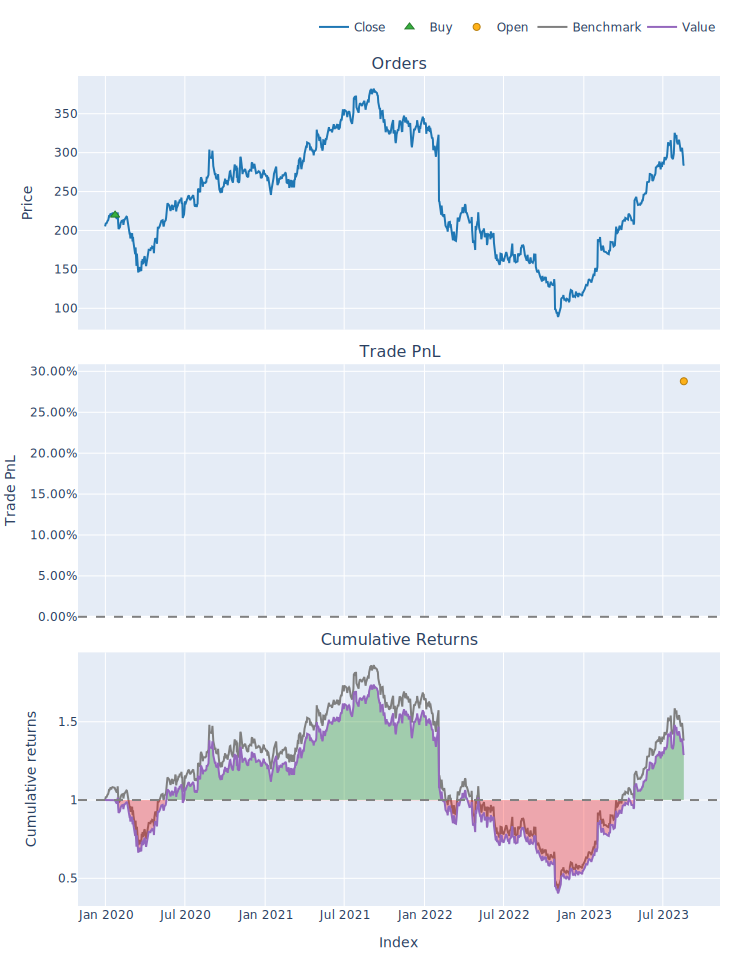

In [11]:
pf[10].plot().show_svg()